In [51]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.applications import ResNet50
import numpy as np
import pandas as pd
import cv2
import os
from glob import glob
from nltk.translate.bleu_score import sentence_bleu


In [53]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 captions.txt		     mine_model_weights.h5   vocab8834.npy
 images			    'model (1).h5'	     vocab.npy
 Images			     model8492.h5	     vocabulary.npy
 mine_model_weights8492.h5   model8834.h5	     web.zip
 mine_model_weights8834.h5   model.h5
 mine_model_weights8889.h5   vocab8492.npy


In [54]:
!ln -s /content/gdrive/My\ Drive/ /mydrive


ln: failed to create symbolic link '/mydrive/My Drive': File exists


In [55]:
cd gdrive/MyDrive

[Errno 2] No such file or directory: 'gdrive/MyDrive'
/content/gdrive/My Drive/image-captioning


In [56]:
cd image-captioning

[Errno 2] No such file or directory: 'image-captioning'
/content/gdrive/My Drive/image-captioning


In [57]:
images_path = 'Images/'
images = glob(images_path+'*.jpg')

In [58]:
max_len=32
a=np.load("vocabulary.npy",allow_pickle=True)
vocab=a.item()
inv_dict = {v:k for k, v in vocab.items()}
resnet=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model=load_model("model.h5")

In [61]:
caption_path = 'captions.txt'
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')


In [62]:
images_features = {}
count = 0
for i in images:
    img = cv2.imread(i)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    
    img = img.reshape(1,224,224,3)
    pred = resnet.predict(img).reshape(2048,)
        
    img_name = i.split('/')[-1]
    
    images_features[img_name] = pred
    
    count += 1
    
    if count > 100:
        break
        
    elif count % 50 == 0:
        print(count)

1/1 [==============================] - 0s 186ms/step
50
1/1 [==============================] - 0s 197ms/step
100
1/1 [==============================] - 0s 191ms/step


In [71]:
captions_dict = {}
for i in captions:
    try:
        img_name = i.split(',')[0]
        caption = i.split(',')[1]
        if img_name in images_features:
            if img_name not in captions_dict:
                captions_dict[img_name] = [caption]
                
            else:
                captions_dict[img_name].append(caption)
        
    except:
        pass

In [64]:
len(captions_dict)

101

In [190]:
cap_list=[]

for i in range(100):
  img = cv2.imread(images[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img = cv2.resize(img, (224,224))

  img = np.reshape(img, (1,224,224,3))
  feature = resnet.predict(img).reshape(1,2048)
  text_inp = ['startofseq']

  count = 0
  caption = ''
  while count < 25:
      count += 1

      encoded = []
      for i in text_inp:
          encoded.append(vocab[i])

      encoded = [encoded]

      encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=32)


      prediction = np.argmax(model.predict([feature, encoded]))

      sampled_word = inv_dict[prediction]

          
      if sampled_word != 'endofseq':
          caption = caption + ' ' + sampled_word

      text_inp.append(sampled_word)
  cap_list.append(caption)


1/1 [==============================] - 0s 41ms/step


In [280]:
img_name_list=[]
score=0
score_list=[]
for i in range(100):
  img_name = images[i]
  reference_captions=captions_dict[img_name.split('/')[-1]]
  bleu_score = sentence_bleu(reference_captions, cap_list[i])
  score_list.append(bleu_score)
  img_name_list.append(img_name)
  score=score+bleu_score

In [282]:
avg_bleu_score=score/100
print("Average Bleu Score : "+str(avg_bleu_score))

Average Bleu Score : 0.7237759639289125


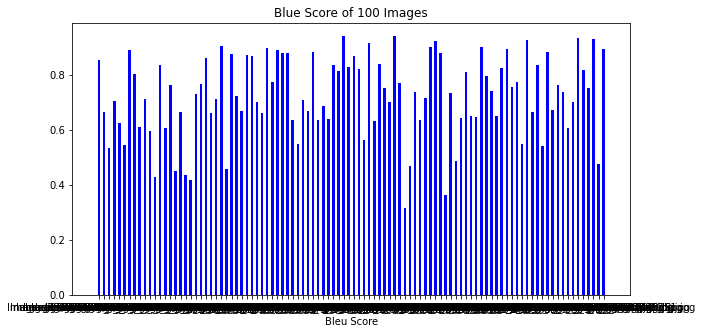

In [283]:
import matplotlib.pyplot as plt
names=img_name_list
values = score_list
  
fig = plt.figure(figsize = (10,5))
 
# creating the bar plot
plt.bar(names, values, color ='blue',width = 0.5)
 
plt.xlabel("Bleu Score")
plt.ylabel("")
plt.title("Blue Score of 100 Images")
plt.show()

In [216]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [285]:
from rouge import Rouge 
rouge = Rouge()


In [286]:
rouge_score=0
rouge_score_list=[]
for i in range(100):
  img_name = images[i]
  reference_captions=captions_dict[img_name.split('/')[-1]]
  score = rouge.get_scores(cap_list[i],reference_captions[0])
  rouge_score_list.append(score)


In [287]:
rouge_1=[]
rouge_2=[]
rouge_l=[]
for i in range(100):
  rouge_1.append(rouge_score_list[i][0]['rouge-1'])
  rouge_2.append(rouge_score_list[i][0]['rouge-2'])
  rouge_l.append(rouge_score_list[i][0]['rouge-l'])

In [291]:
rouge_1_f=[]
rouge_2_f=[]
rouge_l_f=[]

for i in range(100):
  rouge_1_f.append(rouge_1[i]['f'])
  rouge_2_f.append(rouge_2[i]['f'])
  rouge_l_f.append(rouge_l[i]['f'])



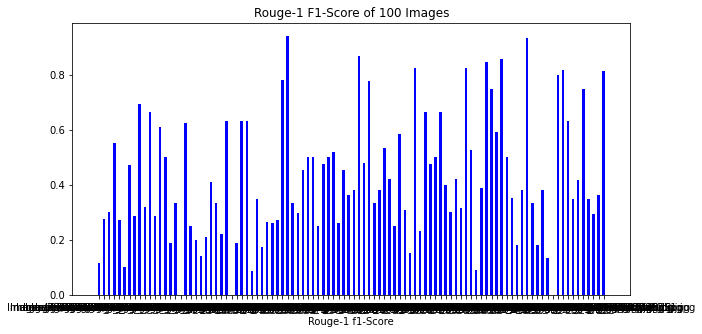

In [294]:
fig2 = plt.figure(figsize = (10,5))
 
# creating the bar plot
plt.bar(img_name_list, rouge_1_f, color ='blue',width = 0.5)
 
plt.xlabel("Rouge-1 f1-Score")
plt.ylabel("")
plt.title("Rouge-1 F1-Score of 100 Images")
plt.show()

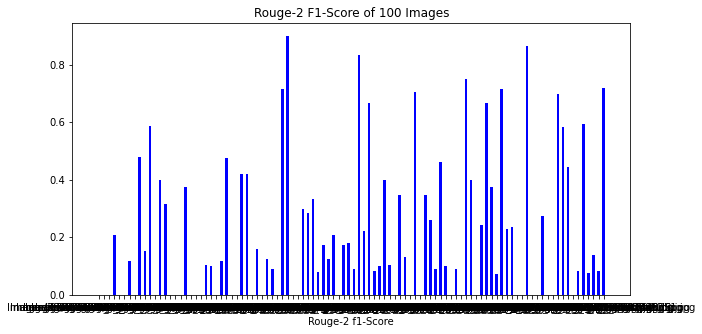

In [295]:
fig3 = plt.figure(figsize = (10,5))
 
# creating the bar plot
plt.bar(img_name_list, rouge_2_f, color ='blue',width = 0.5)
 
plt.xlabel("Rouge-2 f1-Score")
plt.ylabel("")
plt.title("Rouge-2 F1-Score of 100 Images")
plt.show()

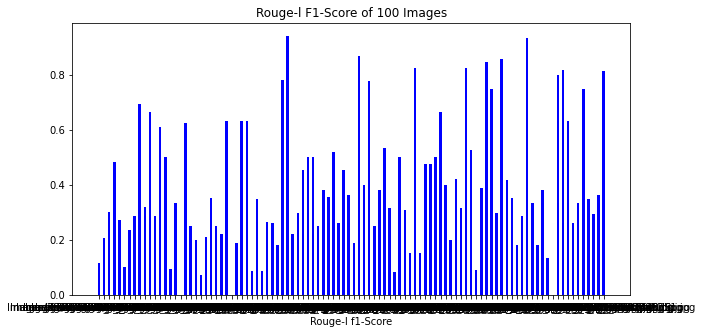

In [296]:
fig4 = plt.figure(figsize = (10,5))
 
# creating the bar plot
plt.bar(img_name_list, rouge_l_f, color ='blue',width = 0.5)
 
plt.xlabel("Rouge-l f1-Score")
plt.ylabel("")
plt.title("Rouge-l F1-Score of 100 Images")
plt.show()

In [297]:
rogue_1_s=0
for i in range(100):
  rogue_1_s=rogue_1_s+rouge_1_f[i]
print(rogue_1_s)

42.605771931299316


In [302]:
avg_rouge_1=sum(rouge_1_f)/100
avg_rouge_2=sum(rouge_2_f)/100
avg_rouge_l=sum(rouge_l_f)/100

In [303]:
print("Average Rouge-1 F1-score : " + str(avg_rouge_1))
print("Average Rouge-2 F1-score : " + str(avg_rouge_2))
print("Average Rouge-l F1-score : " + str(avg_rouge_l))

Average Rouge-1 F1-score : 0.42605771931299313
Average Rouge-2 F1-score : 0.21421628278383217
Average Rouge-l F1-score : 0.3967502175885946
